# Data Preprocessing for Kaggle AMEX dataset

https://www.kaggle.com/competitions/amex-default-prediction/data

This competition had some random looking data where no information on columns was given. This notebook performs some basic data pre-processing on those. Mainly it uses preprocessing code posted by users on the Kaggle competition. These are used as inputs in some other notebooks in this repo, demonstrating Optune hyperparameter optimizations for this dataset.

This dataset contained 1-13 rows of time-series data per customer. Goal was to predict likelihood of default in the next timeframe.


In [1]:
import pandas as pd
import numpy as np

from tqdm import tqdm
import gc
from sklearn import preprocessing

tqdm.pandas()

import time



In [2]:
# https://www.kaggle.com/kyakovlev
# https://www.kaggle.com/competitions/amex-default-prediction/discussion/327534
def amex_metric_mod(y_true, y_pred):

    labels     = np.transpose(np.array([y_true, y_pred]))
    labels     = labels[labels[:, 1].argsort()[::-1]]
    weights    = np.where(labels[:,0]==0, 20, 1)
    cut_vals   = labels[np.cumsum(weights) <= int(0.04 * np.sum(weights))]
    top_four   = np.sum(cut_vals[:,0]) / np.sum(labels[:,0])

    gini = [0,0]
    for i in [1,0]:
        labels         = np.transpose(np.array([y_true, y_pred]))
        labels         = labels[labels[:, i].argsort()[::-1]]
        weight         = np.where(labels[:,0]==0, 20, 1)
        weight_random  = np.cumsum(weight / np.sum(weight))
        total_pos      = np.sum(labels[:, 0] *  weight)
        cum_pos_found  = np.cumsum(labels[:, 0] * weight)
        lorentz        = cum_pos_found / total_pos
        gini[i]        = np.sum((lorentz - weight_random) * weight)

    return 0.5 * (gini[1]/gini[0] + top_four)

In [3]:
cat_cols = ['B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_63', 'D_64', 'D_66', 'D_68'] 


In [4]:
seconds_in_day = 60*60*24


In [5]:
#https://medium.com/bigdatarepublic/advanced-pandas-optimize-speed-and-memory-a654b53be6c2
from typing import List

def optimize_floats(df: pd.DataFrame) -> pd.DataFrame:
    floats = df.select_dtypes(include=['float64']).columns.tolist()
    df[floats] = df[floats].apply(pd.to_numeric, downcast='float')
    return df

def optimize_ints(df: pd.DataFrame) -> pd.DataFrame:
    ints = df.select_dtypes(include=['int64']).columns.tolist()
    df[ints] = df[ints].apply(pd.to_numeric, downcast='integer')
    return df

#this does not seem to work for this dataset, customer id's got duplicated
def optimize_objects(df: pd.DataFrame, datetime_features: List[str]) -> pd.DataFrame:
    for col in df.select_dtypes(include=['object']):
        if col not in datetime_features:
            if not (type(df[col][0])==list):
                num_unique_values = len(df[col].unique())
                num_total_values = len(df[col])
                if float(num_unique_values) / num_total_values < 0.5:
                    df[col] = df[col].astype('category')
        else:
            df[col] = pd.to_datetime(df[col])
    return df

def optimize(df: pd.DataFrame, datetime_features: List[str] = []):
    return optimize_floats(optimize_ints(df))
    #optimize objects was causing categoricals to create extra rows
    #return optimize_floats(optimize_ints(optimize_objects(df, datetime_features)))

In [6]:
def format_time(seconds):
    seconds = int(seconds)
    minutes = seconds // 60
    hours = minutes // 60
    minutes = minutes % 60
    seconds = seconds % 60
    if hours > 0:
        return f"{hours}h, {minutes}m, {seconds}s"
    if minutes > 0:
        return f"{minutes}m, {seconds}s"
    return f"{seconds}s"
        

In [7]:
def find_new_cat_cols(df_from):
    new_cat_cols = []
    for cat_col in cat_cols:
        new_cat_cols.extend([col for col in df_from.columns if col.startswith(cat_col)])
    return new_cat_cols

def label_cat_cols(df1, df2, cat_cols):
    for cat_col in cat_cols:
        encoder = preprocessing.OrdinalEncoder() #or LabelEncoder
        df1[cat_col] = encoder.fit_transform(df1[cat_col]) #TODO: try all cat cols in one call?
        df2[cat_col] = encoder.transform(df2[cat_col])



# Outlier Removal

## Normal Distribution

with z-scores

## Abnormal Distributions

with tukey method

In [8]:
outlier_thresholds_high = {}
outlier_thresholds_low = {}

#assuming the data is normally distributed, this removes outliers using the "three sigma" rule.
#that is 3*std from mean is expected to contain the 0.03% of smallest/highest values.
#those are replaced with the min/mam here (actually just max in this implementation)
def remove_outliers_normal(df, col):
    upper = df[col].mean()+3*df[col].std()
    #even variable outlier_thresholds does not exist in this code, since this method variant was not used by me in the end
    #however, should be trivial to fix both min/max and thresholding
    if col in outlier_thresholds:
        upper = outlier_thresholds[col]
    else:
        outlier_thresholds[col] = upper
    mask = np.abs(df[col] - df[col].mean()) > (3*df[col].std())
    df.loc[mask, col] = upper
    #TODO: fix this version
    
#tukey outlier removal should work for any distribution, not just normal.
#the normal version above is just perhaps more focused for normal distributions
def remove_outliers_tukey(df, col):
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3-q1
    upper = q3 + iqr*2 #tukey default uses 1.5 multiplier, using *2 here to get more extreme outliers
    lower = q1 - iqr*2 #*3 gave std up to 5.5x, lets see 2*

    if col in outlier_thresholds_high:
        upper = outlier_thresholds_high[col]
        lower = outlier_thresholds_low[col]
    else:
        outlier_thresholds_high[col] = upper
        outlier_thresholds_low[col] = lower
        
    high_mask = np.abs(df[col] > upper)
    low_mask = np.abs(df[col] < lower)

    if iqr < 1 and sum(high_mask) > 0:
        upper = df[col].quantile(0.99)
        #IQR = inter-quantile range
#        print(f"capping high scaling of '{col}' due low IQR: {iqr}. New IQR: {upper} vs {lower}")

    if iqr < 1 and sum(low_mask) > 0:    
        lower = df[col].quantile(0.1)
#        print(f"capping low scaling of '{col}' due low IQR: {iqr}. New IQR: {upper} vs {lower}")
    
    #print(sum(mask))
    df.loc[high_mask, col] = upper

    #print(sum(mask))
    df.loc[low_mask, col] = lower
    

In [9]:
def remote_df_outliers(df):
    for col in tqdm(num_cols):
        #note that in its current implementation remove_outliers_tukey does not work across multiple dataframes
        #if the outlier threshold is updated by a latter dataframe, the earlier ones used a different one
        remove_outliers_tukey(df, col)
    

# Data Scaling

Scale the data to be between 0-1 for numerical columns. Otherwise Keras might give funny results.
Using min-max scaler here to get 0-1 instead of Standardscaler that would produce values distributed around 0.
With min-max of 0-1, we can use -1 to represent NaN as a numerical values.
Mostly because Keras chokes on NaN values but -1 works better.

In [10]:
%%time
from sklearn.preprocessing import StandardScaler, MinMaxScaler

def scale_df_minmax(df, cols):
    max_map = {}

    for col in tqdm(cols):
        #sc = StandardScaler() #standardscaler gives high numbers to 1 if most are 0, so trying with minmax
        sc = MinMaxScaler()
        #requireset selecting via [[col]] to get 2d array for standardscaler
        df[col] = sc.fit_transform(df[[col]])
        max_map[col] = df_all[col].max()
    return max_map


CPU times: user 5 µs, sys: 4 µs, total: 9 µs
Wall time: 11 µs


In [11]:
def remove_na_and_inf(df):
    df.replace([np.inf, -np.inf], np.nan,inplace=True)
    df.fillna(-1, inplace=True)

# Add FakeSplitter to Enable Multi-Column Stratified Split

In [12]:
df_train = pd.read_parquet("train.parquet", engine="pyarrow")

In [13]:
df_test = pd.read_parquet("test.parquet", engine="pyarrow")

In [14]:
df_train.shape

(5531451, 190)

In [15]:
df_test.shape

(11363762, 190)

In [16]:
df_train["P_2"].describe()

count    5.485466e+06
mean     6.563343e-01
std      2.446494e-01
min     -4.589548e-01
25%      4.803307e-01
50%      6.942950e-01
75%      8.648159e-01
max      1.010000e+00
Name: P_2, dtype: float64

In [17]:
df_train["fake_splitter"] = df_train["P_2"] > 0.695
df_test["fake_splitter"] = df_test["P_2"] > 0.695

In [18]:
#https://www.kaggle.com/code/roberthatch/exponential-averages-amex-feature-engineering
def count_payments(df):
    for bcol in [f'B_{i}' for i in [11,14,17]]+['D_39','D_131']+[f'S_{i}' for i in [16,23]]:
        for pcol in ['P_2','P_3']:
            if bcol in df.columns:
                result = df[bcol] - df[pcol]
                df[f'{bcol}-{pcol}'] = result.fillna(0)


In [19]:
count_payments(df_train)

In [20]:
count_payments(df_test)

In [21]:
df_train.shape

(5531451, 205)

In [22]:
df_test.shape

(11363762, 205)

In [23]:
df_train_splitter = df_train
df_test_splitter = df_test

In [24]:
df_train.to_parquet('train_splitter.parquet')
df_test.to_parquet('test_splitter.parquet')

# Deloitte features from Kaggle

https://www.kaggle.com/code/cdeotte/xgboost-starter-0-793

In [25]:
def deloitte_process_and_feature_engineer(df):
    # FEATURE ENGINEERING FROM 
    # https://www.kaggle.com/code/huseyincot/amex-agg-data-how-it-created
    all_cols = [c for c in list(df.columns) if c not in ['customer_ID','S_2']]
    cat_features = ["B_30","B_38","D_114","D_116","D_117","D_120","D_126","D_63","D_64","D_66","D_68"]
    num_features = [col for col in all_cols if col not in cat_features]

    #this groupby produces columns that look like this (if printed):
    #MultiIndex([(  'P_2', 'mean'),
    #            (  'P_2',  'std'),
    #            (  'P_2',  'min'),
    #            (  'P_2',  'max'),
    #            (  'P_2', 'last'),
    #            ( 'D_39', 'mean'),
    #            ( 'D_39',  'std'),
    #            ( 'D_39',  'min'),
    #            ( 'D_39',  'max'),
    #            ( 'D_39', 'last'),
    # also, these groupby results appear to be actual dataframes in this case (guess because it call .agg() on them)
    test_num_agg = df.groupby("customer_ID")[num_features].agg(['mean', 'std', 'min', 'max', 'last'])
    #and this line just joins the two parts together for column names such as P_2_mean
    test_num_agg.columns = ['_'.join(x) for x in test_num_agg.columns]

    test_cat_agg = df.groupby("customer_ID")[cat_features].agg(['count', 'last', 'nunique'])
    test_cat_agg.columns = ['_'.join(x) for x in test_cat_agg.columns]

    df = pd.concat([test_num_agg, test_cat_agg], axis=1)
    del test_num_agg, test_cat_agg
    print('shape after engineering', df.shape )
    
    return df

def deloitte_process_all_data():
    global df_train, df_test
    print("loading training set")
    if 'df_train' in vars() or 'df_train' in globals():
        pass
    else:
        df_train = pd.read_parquet("deloitte-data/train.parquet", engine="pyarrow")
    df_train["S_2"] = pd.to_datetime( df_train["S_2"] )
    df_train = df_train.fillna(-127)
    print("feature processing it")
    df_train = deloitte_process_and_feature_engineer(df_train)
    print("loading test set")

    if 'df_test' in vars() or 'df_test' in globals():
        pass
    else:
        df_test = pd.read_parquet("deloitte-data/test.parquet", engine="pyarrow")
    df_test["S_2"] = pd.to_datetime( df_test["S_2"] )
    df_test = df_test.fillna(-127)
    print("feature processing it")
    df_test = deloitte_process_and_feature_engineer(df_test)
    return df_train, df_test

def deloitte_process_and_feature_engineer_large(df):
    # FEATURE ENGINEERING FROM 
    # https://www.kaggle.com/code/huseyincot/amex-agg-data-how-it-created
    all_cols = [c for c in list(df.columns) if c not in ['customer_ID','S_2']]
    cat_features = find_new_cat_cols()
    num_features = [col for col in all_cols if col not in cat_features]

    test_num_agg = df.groupby("customer_ID")[num_features].agg(['mean', 'std'])
    #and this line just joins the two parts together for column names such as P_2_mean
    test_num_agg.columns = ['_'.join(x) for x in test_num_agg.columns]

    df = pd.concat([test_num_agg, test_cat_agg], axis=1)
    del test_num_agg, test_cat_agg
    print('shape after engineering', df.shape )
    
    return df

def deloitte_process_large_data():
    print("loading training set")
    df_train = pd.read_parquet("train_large.parquet", engine="pyarrow")
#    df_train = pd.read_parquet("large_train.parquet", engine="pyarrow")
    print("feature processing it")
    df_train = deloitte_process_and_feature_engineer_large(df_train)
    print("loading test set")
    df_test = pd.read_parquet("test_large.parquet", engine="pyarrow")
#    df_test = pd.read_parquet("large_test.parquet", engine="pyarrow")
    print("feature processing it")
    df_test = deloitte_process_and_feature_engineer_large(df_test)
    return df_train, df_test

df_train, df_test = deloitte_process_all_data()


loading training set
feature processing it
shape after engineering (458913, 993)
loading test set
feature processing it
shape after engineering (924621, 993)


In [26]:
df_train.isna().sum()

P_2_mean           0
P_2_std         5120
P_2_min            0
P_2_max            0
P_2_last           0
                ... 
D_66_last          0
D_66_nunique       0
D_68_count         0
D_68_last          0
D_68_nunique       0
Length: 993, dtype: int64

In [27]:
df_train[df_train.columns[:10]].describe()

,P_2_mean,P_2_std,P_2_min,P_2_max,P_2_last,D_39_mean,D_39_std,D_39_min,D_39_max,D_39_last
count,458913.000000,453793.000000,458913.000000,458913.000000,458913.000000,458913.000000,453793.000000,458913.000000,458913.000000,458913.000000
mean,-0.929136,1.831865,-4.569654,0.039117,-0.190504,4.987931,5.725742,0.214001,16.754258,6.680637
std,11.019608,9.666892,25.097486,9.279095,10.236442,5.605566,5.302279,2.092028,16.100298,13.672650
min,-127.000000,0.000000,-127.000000,-127.000000,-127.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.447584,0.022928,0.356957,0.547550,0.444149,0.500000,0.960769,0.000000,2.000000,0.000000
50%,0.669836,0.038433,0.594695,0.745587,0.679398,3.538462,5.547002,0.000000,16.000000,0.000000
75%,0.854136,0.067619,0.796134,0.906379,0.861351,7.692308,8.166536,0.000000,23.000000,9.000000
max,1.009993,90.515988,1.009993,1.010000,1.009998,156.000000,103.944697,151.000000,183.000000,170.000000


In [28]:
#S2 column?

In [29]:
df_train = df_train.reset_index()

In [30]:
df_target = pd.read_csv("train_labels.csv")
df_train = df_train.merge(df_target, on = 'customer_ID', how = 'left')
df_train["target"] = df_train["target"].astype("int8")

In [31]:
[col for col in df_train.columns if col not in df_test.columns]

['customer_ID', 'target']

In [32]:
df_train.head(5)

,customer_ID,P_2_mean,P_2_std,P_2_min,P_2_max,P_2_last,D_39_mean,D_39_std,D_39_min,D_39_max,...,D_64_count,D_64_last,D_64_nunique,D_66_count,D_66_last,D_66_nunique,D_68_count,D_68_last,D_68_nunique,target
0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,0.933824,0.024194,0.868580,0.960384,0.934745,0.230769,0.832050,0,3,...,13,0,1,13,-1,1,13,6,1,0
1,00000fd6641609c6ece5454664794f0340ad84dddce9a2...,0.899820,0.022119,0.861109,0.929122,0.880519,7.153846,6.743468,0,19,...,13,0,1,13,-1,1,13,6,1,0
2,00001b22f846c82c51f6e3958ccd81970162bae8b007e8...,0.878454,0.028911,0.797670,0.904482,0.880875,0.000000,0.000000,0,0,...,13,2,1,13,-1,1,13,6,1,0
3,000041bdba6ecadd89a52d11886e8eaaec9325906c9723...,0.598969,0.020107,0.567442,0.623392,0.621776,1.538462,3.017046,0,9,...,13,0,1,13,-1,1,13,3,3,0
4,00007889e4fcd2614b6cbe7f8f3d2e5c728eca32d9eb8a...,0.891679,0.042325,0.805045,0.940382,0.871900,0.000000,0.000000,0,0,...,13,0,1,13,1,1,13,6,1,0


In [33]:
df_test = df_test.reset_index()

In [34]:
df_test.head(5)

,customer_ID,P_2_mean,P_2_std,P_2_min,P_2_max,P_2_last,D_39_mean,D_39_std,D_39_min,D_39_max,...,D_63_nunique,D_64_count,D_64_last,D_64_nunique,D_66_count,D_66_last,D_66_nunique,D_68_count,D_68_last,D_68_nunique
0,00000469ba478561f23a92a868bd366de6f6527a684c9a...,0.601387,0.020190,0.568930,0.631315,0.568930,2.222222,3.527668,0,8,...,1,9,3,2,9,-1,1,9,6,2
1,00001bf2e77ff879fab36aa4fac689b9ba411dae63ae39...,0.862166,0.031436,0.794469,0.913501,0.841177,5.076923,6.034091,0,17,...,1,13,0,1,13,-1,1,13,6,1
2,0000210045da4f81e5f122c6bde5c2a617d03eef67f82c...,0.748955,0.061456,0.673112,0.835114,0.697522,6.000000,9.000000,0,23,...,1,13,3,2,13,1,1,13,4,2
3,00003b41e58ede33b8daf61ab56d9952f17c9ad1c3976c...,0.474728,0.028856,0.428457,0.514222,0.513186,15.846154,4.355957,7,23,...,1,13,2,1,13,-1,1,13,5,1
4,00004b22eaeeeb0ec976890c1d9bfc14fd9427e98c4ee9...,0.324100,0.049865,0.254478,0.425764,0.254478,11.846154,6.681394,1,26,...,1,13,2,2,13,-1,1,13,5,2


In [35]:
df_train.to_parquet('train_deloitte.parquet')
df_test.to_parquet('test_deloitte.parquet')
#df_train.to_parquet('train_deloitte_large.parquet')
#df_test.to_parquet('test_deloitte_large.parquet')


In [36]:
df_train.shape

(458913, 995)

# Lagged Features from Kaggle

In [40]:
#https://www.kaggle.com/code/thedevastator/lag-features-are-all-you-need
#0.790

def read_preprocess_data():
    global df_train, df_test
    if 'df_train_splitter' in vars() or 'df_train_splitter' in globals():
        train = df_train_splitter
        test = df_test_splitter
    else:
        train = pd.read_parquet('train_splitter.parquet')
        test = pd.read_parquet('test_splitter.parquet')
    strat = train["fake_splitter"]
    features = train.drop(['customer_ID'], axis = 1).columns.to_list()
    num_cols = [col for col in features if col not in cat_cols+["fake_splitter"]]
    #print(num_cols)

    seconds_in_day = 60*60*24
    seconds_in_day

    train["S_2"] = pd.to_datetime(train["S_2"])
    #https://stackoverflow.com/questions/40881876/python-pandas-convert-datetime-to-timestamp-effectively-through-dt-accessor
    train["S_2"] = train["S_2"].values.astype(np.int64) // 10 ** 9 // seconds_in_day
    test["S_2"] = pd.to_datetime(test["S_2"])
    #https://stackoverflow.com/questions/40881876/python-pandas-convert-datetime-to-timestamp-effectively-through-dt-accessor
    test["S_2"] = test["S_2"].values.astype(np.int64) // 10 ** 9 // seconds_in_day
    
    print("aggregating categoricals")
    for cat_col in tqdm(cat_cols):
        encoder = preprocessing.LabelEncoder()
        train[cat_col] = encoder.fit_transform(train[cat_col])
        test[cat_col] = encoder.transform(test[cat_col])
        
    print("rounding numericals")
    for col in tqdm(num_cols):
        #print(col)
        train[col] = train[col].round(2)
        test[col] = test[col].round(2)
        
    # Train FE
    print('Starting train feature extraction')
    train_num_agg = train.groupby("customer_ID")[num_cols].agg(['first', 'mean', 'std', 'min', 'max', 'last'])
    train_num_agg.columns = ['_'.join(x) for x in train_num_agg.columns]
    train_num_agg.reset_index(inplace = True)

    # Lag Features
    print("lagging cols")
    for col in tqdm(train_num_agg):
        if 'last' in col and col.replace('last', 'first') in train_num_agg:
            train_num_agg[col + '_lag_sub'] = train_num_agg[col] - train_num_agg[col.replace('last', 'first')]
            train_num_agg[col + '_lag_div'] = train_num_agg[col] / train_num_agg[col.replace('last', 'first')]

    train_cat_agg = train.groupby("customer_ID")[cat_cols].agg(['count', 'first', 'last', 'nunique'])
    train_cat_agg.columns = ['_'.join(x) for x in train_cat_agg.columns]
    train_cat_agg.reset_index(inplace = True)
    
    train_labels = pd.read_csv('train_labels.csv')
    train = train_num_agg.merge(train_cat_agg, how = 'inner', on = 'customer_ID').merge(train_labels, how = 'inner', on = 'customer_ID')
    print('Train shape: ', train.shape)    
    del train_num_agg, train_cat_agg        
    gc.collect()
    
    # Test FE
    print('Starting test feature extraction')
    test_num_agg = test.groupby("customer_ID")[num_cols].agg(['first', 'mean', 'std', 'min', 'max', 'last'])
    test_num_agg.columns = ['_'.join(x) for x in test_num_agg.columns]
    test_num_agg.reset_index(inplace = True)

    # Lag Features
    print("lagging cols")
    for col in tqdm(test_num_agg):
        if 'last' in col and col.replace('last', 'first') in test_num_agg:
            test_num_agg[col + '_lag_sub'] = test_num_agg[col] - test_num_agg[col.replace('last', 'first')]
            test_num_agg[col + '_lag_div'] = test_num_agg[col] / test_num_agg[col.replace('last', 'first')]

    test_cat_agg = test.groupby("customer_ID")[cat_cols].agg(['count', 'first', 'last', 'nunique'])
    test_cat_agg.columns = ['_'.join(x) for x in test_cat_agg.columns]
    test_cat_agg.reset_index(inplace = True)
    
    test = test_num_agg.merge(test_cat_agg, how = 'inner', on = 'customer_ID')
    print('Test shape: ', test.shape)
    del test_num_agg, test_cat_agg
    gc.collect()
    
    train["fake_splitter"] = strat
    train.replace([np.inf, -np.inf], np.nan,inplace=True)
    test.replace([np.inf, -np.inf], np.nan,inplace=True)    
    
    # Save files to disk
    train.to_parquet('train_lagged.parquet')
    test.to_parquet('test_lagged.parquet')
    

In [45]:
train = pd.read_parquet('train_splitter.parquet')

In [47]:
train["fake_splitter"].value_counts()

False    2793669
True     2737782
Name: fake_splitter, dtype: int64

In [48]:
read_preprocess_data()

aggregating categoricals


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:05<00:00,  2.00it/s]


rounding numericals


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 192/192 [00:47<00:00,  4.04it/s]


Starting train feature extraction
lagging cols


  0%|                                                                                                        | 0/458913 [00:00<?, ?it/s]/tmp/ipykernel_279/3119241109.py:49: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_num_agg[col + '_lag_sub'] = train_num_agg[col] - train_num_agg[col.replace('last', 'first')]
/tmp/ipykernel_279/3119241109.py:50: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_num_agg[col + '_lag_div'] = train_num_agg[col] / train_num_agg[col.replace('last', 'first')]
/tmp/ipykernel_279/3119241109.py:4

  0%|                                                                                            | 493/458913 [00:00<01:33, 4907.89it/s]/tmp/ipykernel_279/3119241109.py:49: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_num_agg[col + '_lag_sub'] = train_num_agg[col] - train_num_agg[col.replace('last', 'first')]
/tmp/ipykernel_279/3119241109.py:50: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_num_agg[col + '_lag_div'] = train_num_agg[col] / train_num_agg[col.replace('last', 'first')]
/tmp/ipykernel_279/3119241109.py:4

/tmp/ipykernel_279/3119241109.py:49: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_num_agg[col + '_lag_sub'] = train_num_agg[col] - train_num_agg[col.replace('last', 'first')]
/tmp/ipykernel_279/3119241109.py:50: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_num_agg[col + '_lag_div'] = train_num_agg[col] / train_num_agg[col.replace('last', 'first')]
/tmp/ipykernel_279/3119241109.py:49: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor 

  0%|▏                                                                                          | 1153/458913 [00:00<01:39, 4604.75it/s]


Train shape:  (458913, 1582)
Starting test feature extraction
lagging cols


  0%|                                                                                                        | 0/924621 [00:00<?, ?it/s]/tmp/ipykernel_279/3119241109.py:72: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_num_agg[col + '_lag_sub'] = test_num_agg[col] - test_num_agg[col.replace('last', 'first')]
/tmp/ipykernel_279/3119241109.py:73: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_num_agg[col + '_lag_div'] = test_num_agg[col] / test_num_agg[col.replace('last', 'first')]
/tmp/ipykernel_279/3119241109.py:72: Per

  0%|                                                                                            | 355/924621 [00:00<04:22, 3527.33it/s]/tmp/ipykernel_279/3119241109.py:72: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_num_agg[col + '_lag_sub'] = test_num_agg[col] - test_num_agg[col.replace('last', 'first')]
/tmp/ipykernel_279/3119241109.py:73: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_num_agg[col + '_lag_div'] = test_num_agg[col] / test_num_agg[col.replace('last', 'first')]
/tmp/ipykernel_279/3119241109.py:72: Per

/tmp/ipykernel_279/3119241109.py:73: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_num_agg[col + '_lag_div'] = test_num_agg[col] / test_num_agg[col.replace('last', 'first')]
/tmp/ipykernel_279/3119241109.py:72: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_num_agg[col + '_lag_sub'] = test_num_agg[col] - test_num_agg[col.replace('last', 'first')]
/tmp/ipykernel_279/3119241109.py:73: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perfor

/tmp/ipykernel_279/3119241109.py:73: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_num_agg[col + '_lag_div'] = test_num_agg[col] / test_num_agg[col.replace('last', 'first')]
/tmp/ipykernel_279/3119241109.py:72: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_num_agg[col + '_lag_sub'] = test_num_agg[col] - test_num_agg[col.replace('last', 'first')]
/tmp/ipykernel_279/3119241109.py:73: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perfor

/tmp/ipykernel_279/3119241109.py:73: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_num_agg[col + '_lag_div'] = test_num_agg[col] / test_num_agg[col.replace('last', 'first')]
/tmp/ipykernel_279/3119241109.py:72: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_num_agg[col + '_lag_sub'] = test_num_agg[col] - test_num_agg[col.replace('last', 'first')]
/tmp/ipykernel_279/3119241109.py:73: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perfor

  0%|                                                                                           | 1153/924621 [00:00<04:39, 3305.10it/s]


Test shape:  (924621, 1581)


/tmp/ipykernel_279/3119241109.py:84: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train["fake_splitter"] = strat


In [49]:
def read_data():
    train = pd.read_parquet('train_lagged.parquet')
    test = pd.read_parquet('test_lagged.parquet')
    return train, test

In [50]:
train, test = read_data()

# Large set

This one simply creates a DF where each target entity is assumed to have 13 rows of data, and all those 13 are pivoted to one row. So someting like this:

- Customer 1: row1 (10 values) (time step1 for customer 1)
- Customer 1: row2 (10 values) (time step2 for customer 1)
- ,,,, until row 13 for customer 1

becomes something like this:

- C1: A_0, A_1, A_2, ... A_12, B_0, B_1, B_2, ...

So all data per a customer is put into a single row for each customer. No data for a time step/customer results in NaN values in that dataframe slot.

In [64]:
#if 'df_train' in vars() or 'df_train' in globals():
#    pass
#else:
#    df_train = pd.read_parquet("train.parquet", engine="pyarrow")
df_train = pd.read_parquet("train.parquet", engine="pyarrow")
df_train.head()


,customer_ID,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,...,D_136,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145
0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-03-09,0.938469,0,0.008724,1.006838,0.009228,0.124035,0.0,0.004709,...,-1,-1,-1,0,0,0.0,NaN,0,0.000610,0
1,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-04-07,0.936665,0,0.004923,1.000653,0.006151,0.126750,0.0,0.002714,...,-1,-1,-1,0,0,0.0,NaN,0,0.005492,0
2,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-05-28,0.954180,3,0.021655,1.009672,0.006815,0.123977,0.0,0.009423,...,-1,-1,-1,0,0,0.0,NaN,0,0.006986,0
3,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-06-13,0.960384,0,0.013683,1.002700,0.001373,0.117169,0.0,0.005531,...,-1,-1,-1,0,0,0.0,NaN,0,0.006527,0
4,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-07-16,0.947248,0,0.015193,1.000727,0.007605,0.117325,0.0,0.009312,...,-1,-1,-1,0,0,0.0,NaN,0,0.008126,0


In [65]:
cat_cols = find_new_cat_cols(df_train)

In [66]:
num_cols = [col for col in df_train.columns if col not in cat_cols if col != "customer_ID" and col != "fake_splitter"]


In [67]:
#if 'df_test' in vars() or 'df_test' in globals():
#    pass
#else:
#    df_test = pd.read_parquet("test.parquet", engine="pyarrow")
#df_test = df_test.reset_index()
df_test = pd.read_parquet("test.parquet", engine="pyarrow")
df_test.head()

,customer_ID,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,...,D_136,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145
0,00000469ba478561f23a92a868bd366de6f6527a684c9a...,2019-02-19,0.631315,0,0.010728,0.814497,0.0,0.168651,0.0,0.002347,...,-1,-1,-1,-1,0,NaN,NaN,-1,0.008281,-1
1,00000469ba478561f23a92a868bd366de6f6527a684c9a...,2019-03-25,0.587042,0,0.011026,0.810848,0.0,0.241389,0.0,0.009132,...,-1,-1,-1,0,0,0.0,NaN,0,0.003753,0
2,00000469ba478561f23a92a868bd366de6f6527a684c9a...,2019-04-25,0.609056,0,0.016390,1.004620,0.0,0.266976,0.0,0.004192,...,-1,-1,-1,0,0,0.0,NaN,0,0.002156,0
3,00000469ba478561f23a92a868bd366de6f6527a684c9a...,2019-05-20,0.614911,0,0.021672,0.816549,0.0,0.188947,0.0,0.015325,...,-1,-1,-1,0,0,0.0,NaN,0,0.005206,0
4,00000469ba478561f23a92a868bd366de6f6527a684c9a...,2019-06-15,0.591673,8,0.015923,0.810456,0.0,0.180035,0.0,0.011281,...,-1,-1,-1,0,0,0.0,NaN,0,0.007421,0


In [68]:
df_test.shape

(11363762, 190)

In [69]:
df_all = pd.concat([df_train, df_test], axis=0)
df_all.shape

(16895213, 190)

In [70]:
train_size = df_train.shape[0]
train_size

5531451

In [71]:
new_cat_cols = find_new_cat_cols(df_all)
cat_cols = new_cat_cols

In [72]:
del df_train
del df_test

In [73]:
df_all[cat_cols].dtypes.value_counts()

Series([], dtype: int64)

In [74]:
from sklearn import preprocessing

for cat_col in tqdm(cat_cols):
    le = preprocessing.LabelEncoder()
    df_all[cat_col] = le.fit_transform(df_all[cat_col])

0it [00:00, ?it/s]


## Convert Date to Seconds

In [75]:
seconds_in_day = 60*60*24
seconds_in_day

df_all["S_2"] = pd.to_datetime(df_all["S_2"])
#https://stackoverflow.com/questions/40881876/python-pandas-convert-datetime-to-timestamp-effectively-through-dt-accessor
df_all["S_2"] = df_all["S_2"].values.astype(np.int64) // 10 ** 9 // seconds_in_day

# Check Value Distributions to Select Outlier Removal Algo

In [76]:
!pip install seaborn

--- Logging error ---
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/pip/_internal/utils/logging.py", line 177, in emit
    self.console.print(renderable, overflow="ignore", crop=False, style=style)
  File "/usr/local/lib/python3.8/dist-packages/pip/_vendor/rich/console.py", line 1752, in print
    extend(render(renderable, render_options))
  File "/usr/local/lib/python3.8/dist-packages/pip/_vendor/rich/console.py", line 1390, in render
    for render_output in iter_render:
  File "/usr/local/lib/python3.8/dist-packages/pip/_internal/utils/logging.py", line 134, in __rich_console__
    for line in lines:
  File "/usr/local/lib/python3.8/dist-packages/pip/_vendor/rich/segment.py", line 245, in split_lines
    for segment in segments:
  File "/usr/local/lib/python3.8/dist-packages/pip/_vendor/rich/console.py", line 1368, in render
    renderable = rich_cast(renderable)
  File "/usr/local/lib/python3.8/dist-packages/pip/_vendor/rich/protocol.py", line 36

In [77]:
import seaborn as sb

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='D_50', ylabel='Density'>

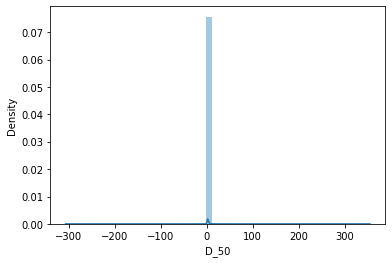

In [78]:
sb.distplot(df_all["D_50"])

Hard to say from above if it is normal distributed or not but I will try Tukey first to be sure (works in all cases):

In [79]:
df_all["D_50"].quantile(0.01)

0.0023464027

In [80]:
df_all["D_50"].quantile(0.99)

1.0716107

In [81]:
#remove_outliers_tukey(df_all, "D_50")
for col in tqdm(num_cols):
    remove_outliers_tukey(df_all, col)
    

100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 189/189 [08:28<00:00,  2.69s/it]


/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='D_50', ylabel='Density'>

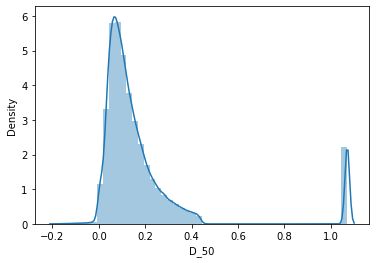

In [82]:
sb.distplot(df_all["D_50"])

So it was not normally distributed (see above) and Tukey was a good choice.

# Min-Max Scale the Data

First check categorial data types before trying the scaler (categoricals should remain as are as they are not to be scaled):

In [83]:
df_all[cat_cols].dtypes.value_counts()

Series([], dtype: int64)

In [84]:
%%time

scale_df_minmax(df_all, num_cols)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 189/189 [05:55<00:00,  1.88s/it]

CPU times: user 2min 49s, sys: 3min, total: 5min 50s
Wall time: 5min 55s


{'S_2': 1.0,
 'P_2': 1.0,
 'D_39': 1.0,
 'B_1': 1.0,
 'B_2': 1.0,
 'R_1': 1.0,
 'S_3': 1.0000001,
 'D_41': 1.0,
 'B_3': 1.0,
 'D_42': 0.99999994,
 'D_43': 1.0,
 'D_44': 1.0,
 'B_4': 1.0,
 'D_45': 1.0,
 'B_5': 1.0,
 'R_2': 1.0,
 'D_46': 1.0,
 'D_47': 0.99999994,
 'D_48': 0.99999994,
 'D_49': 1.0,
 'B_6': 0.9999999,
 'B_7': 1.0,
 'B_8': 1.0,
 'D_50': 1.0,
 'D_51': 1.0,
 'B_9': 1.0,
 'R_3': 1.0,
 'D_52': 0.99999994,
 'P_3': 1.0,
 'B_10': 1.0,
 'D_53': 1.0,
 'S_5': 1.0,
 'B_11': 1.0,
 'S_6': 1.0,
 'D_54': 0.0,
 'R_4': 1.0,
 'S_7': 0.99999994,
 'B_12': 1.0,
 'S_8': 1.0,
 'D_55': 1.0,
 'D_56': 0.99999994,
 'B_13': 1.0,
 'R_5': 1.0,
 'D_58': 1.0,
 'S_9': 1.0,
 'B_14': 1.0,
 'D_59': 0.9999999999999999,
 'D_60': 1.0,
 'D_61': 0.99999994,
 'B_15': 1.0,
 'S_11': 1.0,
 'D_62': 1.0,
 'D_63': 1.0,
 'D_64': 1.0,
 'D_65': 1.0,
 'B_16': 1.0,
 'B_17': 1.0,
 'B_18': 1.0000001,
 'B_19': 1.0,
 'D_66': 1.0,
 'B_20': 1.0,
 'D_68': 1.0,
 'S_12': 1.0,
 'R_6': 1.0,
 'S_13': 1.0,
 'B_21': 1.0,
 'D_69': 1.0,
 'B_

Above is good to check that the outlier removal resulted in reasonable results. In this case all max values are about 1 so it is ok.

In another case we might also want to check min values.

In [85]:
#max_map

# Optimize Memory Use

Optimize for memory use:

In [86]:
%%time
df_all = optimize(df_all)


CPU times: user 32.9 s, sys: 37.5 s, total: 1min 10s
Wall time: 1min 11s


Check the categoricals still unchanged as expected:

In [87]:
df_all[cat_cols].dtypes.value_counts()

Series([], dtype: int64)

# One-Hot Encode Categoricals as Needed

In [88]:
create_embeddings = True

In [89]:
%%time
if not create_embeddings:
    #one-hot encode all categorical data if not using embeddings in later phase
    onehot = pd.get_dummies(df_all[cat_cols].astype(str))
    print(onehot.dtypes)
    print(onehot.shape)
    df_all_hot = pd.concat([df_all, onehot], axis=1)
    print(df_all_hot.shape)
    del df_all
    df_all_hot = df_all_hot.drop(cat_cols, axis=1)
    print(df_all_hot.shape)
    new_cat_cols = find_new_cat_cols(df_all_hot)
    gc.collect()
    remove_na_and_inf(df_all_hot)
    print(df_all_hot[new_cat_cols].dtypes.value_counts())
    df_train = df_all_hot[:train_size].copy()
    df_test = df_all_hot[train_size:].copy()
    del df_all_hot
    del onehot
else:
    #if using embeddings, leave data as is (later Keras model will learn from this the mapping)
    df_train = df_all[:train_size].copy()
    df_test = df_all[train_size:].copy()


CPU times: user 731 ms, sys: 730 ms, total: 1.46 s
Wall time: 1.52 s


In [90]:
df_train.shape

(5531451, 190)

In [91]:
df_test.shape

(11363762, 190)

In [92]:
df_train["customer_ID"].nunique()

458913

In [93]:
df_target = pd.read_csv("train_labels.csv")
df_target.head()

,customer_ID,target
0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,0
1,00000fd6641609c6ece5454664794f0340ad84dddce9a2...,0
2,00001b22f846c82c51f6e3958ccd81970162bae8b007e8...,0
3,000041bdba6ecadd89a52d11886e8eaaec9325906c9723...,0
4,00007889e4fcd2614b6cbe7f8f3d2e5c728eca32d9eb8a...,0


In [94]:
df_train = df_train.sort_values(['customer_ID', 'S_2'])
df_test = df_test.sort_values(['customer_ID', 'S_2'])

In [95]:
df_target = df_target.sort_values(["customer_ID"])

In [96]:
df_train[new_cat_cols].dtypes.value_counts()

Series([], dtype: int64)

In [97]:
df_train_grouped = df_train.groupby('customer_ID')
#df_train_grouped = df_train.sort_values('S_2').groupby('customer_ID')
df_train_sizes = df_train_grouped.size()
df_train_sizes.value_counts().sort_index()

1       5120
2       6098
3       5778
4       4673
5       4671
6       5515
7       5198
8       6110
9       6411
10      6721
11      5961
12     10623
13    386034
dtype: int64

In [98]:
#data should be sorted now by customer id + time, so collect unique customer ID's in correct order:
customer_IDs = df_train_grouped.size().reset_index()["customer_ID"]
customer_IDs

0         0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...
1         00000fd6641609c6ece5454664794f0340ad84dddce9a2...
2         00001b22f846c82c51f6e3958ccd81970162bae8b007e8...
3         000041bdba6ecadd89a52d11886e8eaaec9325906c9723...
4         00007889e4fcd2614b6cbe7f8f3d2e5c728eca32d9eb8a...
                                ...                        
458908    ffff41c8a52833b56430603969b9ca48d208e7c192c6a4...
458909    ffff518bb2075e4816ee3fe9f3b152c57fc0e6f01bf7fd...
458910    ffff9984b999fccb2b6127635ed0736dda94e544e67e02...
458911    ffffa5c46bc8de74f5a4554e74e239c8dee6b9baf38814...
458912    fffff1d38b785cef84adeace64f8f83db3a0c31e8d92ea...
Name: customer_ID, Length: 458913, dtype: object

In [99]:
df_target["customer_ID"].equals(customer_IDs)

True

# Pivot Data to all on Same Row per Customer ID

In [100]:
#TODO: process in df_all? maybe sorting not possible? have to add train column?
df_new = pd.DataFrame()
old_cols = [col for col in df_train.columns if col != "customer_ID"]
for col in tqdm(old_cols):
    df_f = df_train_grouped[col].agg(lambda x: list(x))
    new_cols = []
    for x in range(13):
        new_cols.append(f"{col}_{x+1}")
    col_df = pd.DataFrame(df_f.tolist(), columns=new_cols)
#    col_df = pd.DataFrame(df_f[col].tolist(), columns=new_cols)
    col_df = optimize(col_df)
    df_new = pd.concat([df_new, col_df], axis=1)
    del col_df


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 189/189 [29:40<00:00,  9.42s/it]


In [101]:
df_new["customer_ID"] = customer_IDs
df_new["target"] = df_target["target"]

/tmp/ipykernel_279/1654804753.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_new["customer_ID"] = customer_IDs
/tmp/ipykernel_279/1654804753.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_new["target"] = df_target["target"]


In [102]:
#have to fill na's here as the above groupby creates them, and Keras will choke on them
remove_na_and_inf(df_new)

In [107]:
df_new.rename(columns = {'fake_splitter_1':'fake_splitter'}, inplace = True)

In [108]:
cols_to_drop = [f"fake_splitter_{col+2}" for col in range(12)]
cols_to_drop

['fake_splitter_2',
 'fake_splitter_3',
 'fake_splitter_4',
 'fake_splitter_5',
 'fake_splitter_6',
 'fake_splitter_7',
 'fake_splitter_8',
 'fake_splitter_9',
 'fake_splitter_10',
 'fake_splitter_11',
 'fake_splitter_12',
 'fake_splitter_13']

In [113]:
cols_to_drop = [col for col in df_new.columns if "fake" in col]

In [114]:
df_new = df_new.drop(cols_to_drop, axis=1)

In [115]:
postfix = ""
if create_embeddings:
    postfix = "_embeddings"

In [116]:
filename = f"large_train{postfix}.parquet"
filename

'large_train_embeddings.parquet'

In [117]:
df_new.to_parquet(filename)

In [118]:
df_new.shape

(458913, 2459)

In [120]:
#df_new["fake_splitter"].value_counts()

In [121]:
del df_f
del df_train
del df_new

In [122]:
pd.reset_option("display.max_rows")
pd.reset_option("display.min_rows")
pd.reset_option("display.max_columns")


In [123]:
#pd.set_option('display.max_rows', None)


# Same for Kaggle Test Set as Above for Train Set

In [124]:
df_test.memory_usage().sum() / 1024**2

8366.417182922363

In [125]:
df_test.dtypes.value_counts()

float32    189
object       1
dtype: int64

In [126]:
#df_train.to_parquet("deloitte-data/keras_train.parquet")


In [127]:
cols_to_drop = [col for col in df_test.columns if "fake" in col]
cols_to_drop

[]

In [128]:
df_test.select_dtypes(include=['object']).columns

Index(['customer_ID'], dtype='object')

In [129]:
df_test = df_test.drop(cols_to_drop, axis=1)

In [130]:
df_test = df_test.sort_values(['customer_ID', 'S_2'])

In [131]:
df_test_grouped = df_test.groupby('customer_ID')
df_test_sizes = df_test_grouped.size()
df_test_sizes.value_counts().sort_index()

1       5827
2       8174
3       7803
4       8348
5       8419
6       8833
7       9653
8       9775
9      10552
10      9638
11      9943
12     16327
13    811329
dtype: int64

In [132]:
#df_test["customer_ID"].nunique()
customer_IDs = df_test_grouped.size().reset_index()["customer_ID"]
customer_IDs

0         00000469ba478561f23a92a868bd366de6f6527a684c9a...
1         00001bf2e77ff879fab36aa4fac689b9ba411dae63ae39...
2         0000210045da4f81e5f122c6bde5c2a617d03eef67f82c...
3         00003b41e58ede33b8daf61ab56d9952f17c9ad1c3976c...
4         00004b22eaeeeb0ec976890c1d9bfc14fd9427e98c4ee9...
                                ...                        
924616    ffff952c631f2c911b8a2a8ca56ea6e656309a83d2f64c...
924617    ffffcf5df59e5e0bba2a5ac4578a34e2b5aa64a1546cd3...
924618    ffffd61f098cc056dbd7d2a21380c4804bbfe60856f475...
924619    ffffddef1fc3643ea179c93245b68dca0f36941cd83977...
924620    fffffa7cf7e453e1acc6a1426475d5cb9400859f82ff61...
Name: customer_ID, Length: 924621, dtype: object

In [133]:
df_new = pd.DataFrame()
old_cols = [col for col in df_test.columns if col != "customer_ID"]
for col in tqdm(old_cols):
    df_f = df_test_grouped[col].agg(lambda x: list(x))
    new_cols = []
    for x in range(13):
        new_cols.append(f"{col}_{x+1}")
    col_df = pd.DataFrame(df_f.tolist(), columns=new_cols)
#    col_df = pd.DataFrame(df_f[col].tolist(), columns=new_cols)
    col_df = optimize(col_df)
    df_new = pd.concat([df_new, col_df], axis=1)
    del col_df


  1%|▌                                                                                                | 1/189 [00:32<1:41:18, 32.33s/it]


KeyboardInterrupt: 

In [ ]:
#have to fill na's here as the above groupby creates them
remove_na_and_inf(df_new)

In [ ]:
df_new.shape

In [ ]:
customer_IDs.shape

In [ ]:
df_new["customer_ID"] = customer_IDs

In [ ]:
df_new.rename(columns = {'fake_splitter_1':'fake_splitter'}, inplace = True)

In [ ]:
#df_new = df_new.drop(cols_to_drop, axis=1)

In [ ]:
filename = f"large_test{postfix}.parquet"
filename

In [ ]:
df_new.to_parquet(filename)

# For Keras Embedding

The above "large" dataset also has option for embeddings type categorical data, this one does the same but for the original dataset (no derived statistics as above sets).

In [ ]:
if 'df_train' in vars() or 'df_train' in globals():
    print("df_train loaded, skipping load")
    pass
else:
    df_train = pd.read_parquet("train.parquet", engine="pyarrow")
    print("loaded training data")
df_train.head()


In [ ]:
df_train.shape

In [ ]:
cat_cols = find_new_cat_cols(df_train)
cat_cols

In [ ]:
num_cols = [col for col in df_train.columns if col not in cat_cols if col != "customer_ID" and col != "fake_splitter"]


In [ ]:
if 'df_test' in vars() or 'df_test' in globals():
    print("df_test already loaded, skipping load")
    pass
else:
    df_test = pd.read_parquet("test.parquet", engine="pyarrow")
    print("loaded test data")
#df_test = df_test.reset_index()
df_test.head()

In [ ]:
df_test.shape

In [ ]:
df_all = pd.concat([df_train, df_test], axis=0)
df_all.shape

In [ ]:
df_all["S_2"] = pd.to_datetime(df_all["S_2"])
#https://stackoverflow.com/questions/40881876/python-pandas-convert-datetime-to-timestamp-effectively-through-dt-accessor
df_all["S_2"] = df_all["S_2"].values.astype(np.int64) // 10 ** 9 // seconds_in_day


In [ ]:
train_size = df_train.shape[0]
train_size

In [ ]:
unique_counts = df_all.nunique()
small_count_cols = unique_counts[unique_counts < 10]
small_count_cols

In [ ]:
small_count_cols = small_count_cols.drop("fake_splitter")


In [ ]:
new_cat_cols = find_new_cat_cols(df_all)
cat_cols = new_cat_cols
cat_cols

In [ ]:
#small_count_cols

In [ ]:
embeddables = set(cat_cols).union(set(small_count_cols.index))
len(embeddables)

In [ ]:
"B_30" in embeddables

In [ ]:
cat_cols = embeddables

In [ ]:
num_cols = [col for col in df_train.columns if col not in cat_cols if col != "customer_ID" and col != "fake_splitter"]


In [ ]:
remote_df_outliers(df_all)

In [ ]:
scale_df_minmax(df_all)

In [ ]:
cat_cols

In [ ]:
remove_na_and_inf(df_all)

In [ ]:
df_train = df_all[:train_size].copy()
df_test = df_all[train_size:].copy()

In [ ]:
df_target = pd.read_csv("train_labels.csv")
#df_train = pd.read_parquet('train_embedding.parquet')

In [ ]:
df_train = df_train.merge(df_target, on = 'customer_ID', how = 'left')


In [ ]:
df_train.to_parquet('train_embedding.parquet')
df_test.to_parquet('test_embedding.parquet')
